### Data Modeling 

In [11]:
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

## Time Series Task #1

1. Convert the longitudinal blood pressure measurements into a proper time series:
   - Create a pandas Series with DatetimeIndex using `visit_date`
   - Handle any missing or duplicate measurements appropriately
   - Tips: 
     - Use `pd.to_datetime()` with format='%Y-%m-%d' for reliable parsing
     - Handle duplicates with `duplicated()` and appropriate aggregation
     - Consider timezone handling with `tz_localize()` if neededs
     - Use `interpolate()` or `fillna()` for missing values

In [12]:
# load dataset and create series 
df = pd.read_csv("patient_longitudinal.csv", sep='\t')
df['visit_date'] = pd.to_datetime(df['visit_date'])

In [13]:
# handle duplicates 
df = df.groupby(['patient_id', 'visit_date']).mean().reset_index()

# make visit_date a datetimeindex
df.set_index('visit_date', inplace=True)

# missing values
df['bp_systolic'] = df['bp_systolic'].interpolate() 

#print(data.head)

## Time Series Task #2

2. Analyze blood pressure trends:
   - Resample the data to monthly frequency using mean aggregation
   - Calculate 3-month moving averages to smooth out short-term fluctuations
   - Visualize both the original and smoothed trends
   - Tips:
     - Use `resample('ME').mean()` for month-end frequency
     - Add `min_periods` to `rolling()` to handle edge cases
     - Consider `interpolate()` method for gaps
     - Use `ewm()` for exponential weighted alternatives

/tmp/ipykernel_2110/2663168932.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthFreq = df['bp_systolic'].resample('M').mean()


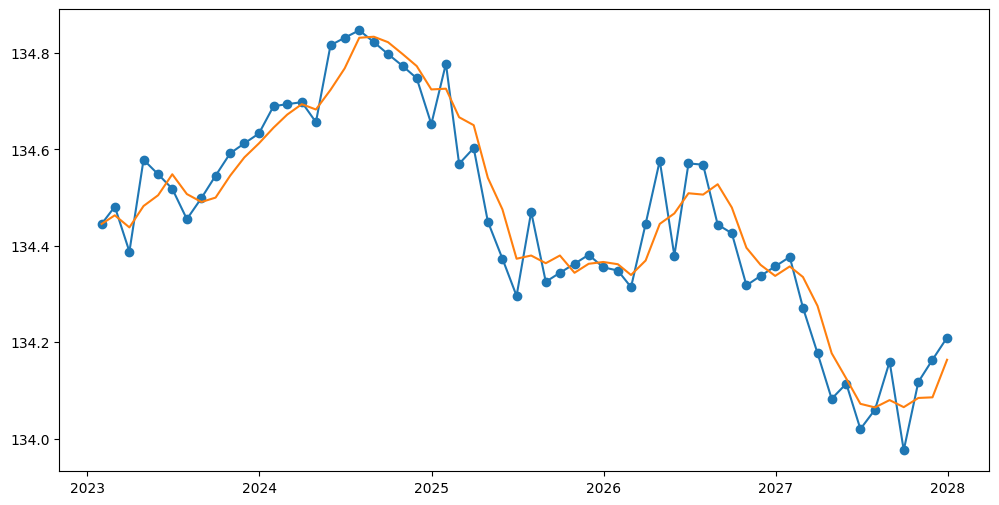

In [14]:
# resample monthly frequency 
monthFreq = df['bp_systolic'].resample('M').mean() 

# handle missing values
monthFreq = monthFreq.interpolate()

# 3 month moving averages 
movingAvg3 = monthFreq.rolling(window = 3, min_periods = 1).mean() 

# visualization of original and smoothed trends
plt.figure(figsize = (12,6))
plt.plot(monthFreq, label = 'Original Blood Pressure Monthly Trend', marker = 'o')
plt.plot(movingAvg3, label = '3 Month Moving Average Trend', linestyle = '-')  

## Statistical Modeling Task #1

1. Analyze factors affecting baseline blood pressure:
   - Use statsmodels OLS to predict `bp_systolic`
   - Include `age`, `bmi`, `smoking`, and `diabetes` as predictors
   - Interpret the coefficients and their p-values
   - Assess model fit using R-squared and diagnostic plots
   - Tips:
     - Create feature matrix `X` with predictors and add constant term using `sm.add_constant()`
     - Use `sm.OLS(y, X).fit()` to fit the model
     - Use `summary()` to examine p-values and confidence intervals
     - Plot residuals vs fitted values and Q-Q plot
     - Consider robust standard errors with `HC3` covariance type

                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     2705.
Date:                Wed, 06 Nov 2024   Prob (F-statistic):               0.00
Time:                        22:22:19   Log-Likelihood:            -2.5551e+05
No. Observations:               60000   AIC:                         5.110e+05
Df Residuals:                   59995   BIC:                         5.111e+05
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        110.2999      0.457    241.359      0.0

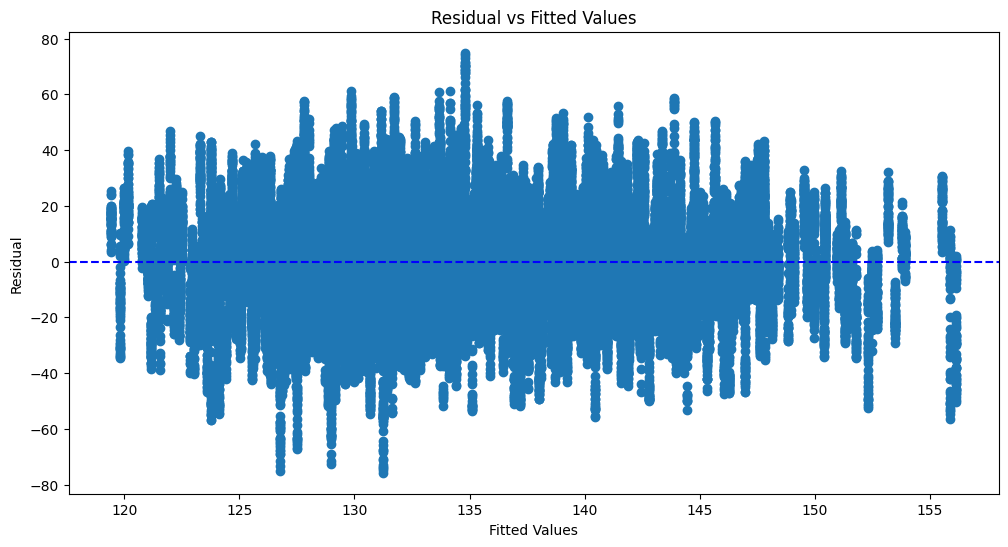

<Figure size 1200x600 with 0 Axes>

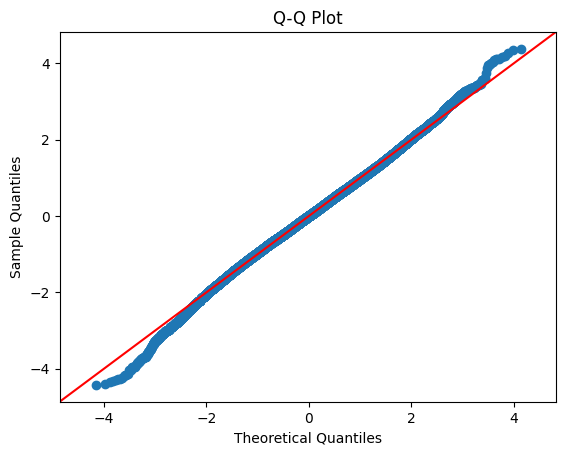

In [19]:
y = df['bp_systolic'] # variable we are measuring
X = df[['age', 'bmi', 'smoking', 'diabetes']] # feature matrix 
X = sm.add_constant(X) # constant term 

model = sm.OLS(y, X).fit(cov_type = 'HC3') # fit the model 
print(model.summary()) # print model summary 

# plot residuals vs fitted values 
plt.figure(figsize = (12,6))

plt.scatter(model.fittedvalues, model.resid)
plt.axhline(y=0, color='blue', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residual')
plt.title('Residual vs Fitted Values')
plt.show()

# Q-Q plot 
plt.figure(figsize = (12,6))
sm.qqplot(model.resid, line = '45', fit = True)
plt.title('Q-Q Plot')
plt.show()

## Statistical Modeling Task #2

2. Model treatment effectiveness:
   - Fit a GLM with binomial family to predict treatment success
   - Use baseline characteristics and `adherence` as predictors
   - Report odds ratios and their confidence intervals
   - Assess model fit using deviance and diagnostic plots
   - Tips:
     - Create feature matrix `X` with predictors and add constant term
     - Use `sm.GLM(y, X, family=sm.families.Binomial()).fit()`
     - Get odds ratios with `np.exp(params)`
     - Check residual deviance vs null deviance
     - Use `influence()` to detect influential observations